<a href="https://colab.research.google.com/github/maroufpaul/gpr_optimizer/blob/main/GaussianProcess_NeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neighbors import KernelDensity
from scipy import stats
from scipy.stats import skew, kurtosis
from scipy.stats import norm, laplace, beta
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **STEP 1: Data Generation**

In [4]:
def generate_norm_distributions(x_values, num_distributions=11, scale_factor=8):
    """
    Generate a list of normal distributions.
    """
    norm_values = []
    for _ in range(num_distributions):
        mean = np.random.uniform(-4, 4)
        std_dev = np.random.uniform(0.01, 1)
        norm_dist = norm(mean, std_dev)
        norm_values.append(scale_factor * norm_dist.pdf(x_values))
    return norm_values

def generate_laplace_distributions(cleaned_x, num_distributions=10, scale_factor=12):
    """
    Generate a list of Laplace distributions.
    """
    laplace_values = []
    for i in range(num_distributions):
        loc = np.random.uniform(0.5, 5) if i % 2 == 0 else np.random.uniform(0, 1)
        scale = np.random.uniform(0.1, 5) if i < 3 else np.random.uniform(0.15, 1)
        laplace_dist = laplace(loc, scale)
        laplace_values.append(scale_factor * laplace_dist.pdf(cleaned_x))
    return laplace_values

def generate_beta_distributions(cleaned_x, num_distributions=4, scale_factors=(1, 0.5)):
    """
    Generate a list of Beta distributions.
    """
    beta_values = []
    for i in range(num_distributions):
        a = np.random.uniform(0.5, 5)
        b = np.random.uniform(0.5, 5)
        beta_dist = beta(a, b)
        scale = scale_factors[i % len(scale_factors)]
        beta_values.append(scale * beta_dist.pdf(cleaned_x))
    return beta_values

def generate_random_weights(num_weights, range_min=-0.5, range_max=0.5):
    """
    Generate random weights for combining distributions.
    """
    return [np.random.uniform(range_min, range_max) for _ in range(num_weights)]

def generate_dominance_factor():
    """
    Generate a dominance factor, with a small chance for larger values.
    """
    value = np.random.uniform(0, 1)
    return np.random.uniform(2, 5) if value > 0.8 else 1

def GetADistribution():
    # Generate x values
    POINTS = int(np.random.uniform(200, 500))
    x_values = np.random.uniform(-4, 4, POINTS)
    x_values.sort()
    cleaned_x = (x_values + 4) / 8

    # Generate distributions
    norm_values = generate_norm_distributions(x_values)
    laplace_values = generate_laplace_distributions(cleaned_x)
    beta_values = generate_beta_distributions(cleaned_x)

    # Generate noise
    noise = np.random.normal(0, np.random.uniform(0.2, 1), POINTS)

    # Random weights and dominance factors
    weights = generate_random_weights(25)
    dominance_factors = [generate_dominance_factor() for _ in range(3)]

    # Combine distributions into the orchestra
    ORCHESTRA = (
        weights[0] * dominance_factors[0] * beta_values[0] +
        weights[1] * beta_values[1] +
        weights[2] * norm_values[0] +
        weights[3] * norm_values[1] +
        weights[4] * norm_values[2] +
        weights[5] * laplace_values[0] +
        weights[6] * dominance_factors[1] * laplace_values[1] +
        weights[7] * norm_values[3] +
        weights[8] * norm_values[4] +
        weights[9] * norm_values[5] +
        weights[10] * laplace_values[2] +
        weights[11] * laplace_values[3] +
        weights[12] * norm_values[6] +
        weights[13] * norm_values[7] +
        weights[14] * norm_values[8] +
        weights[15] * norm_values[9] +
        weights[16] * dominance_factors[2] * norm_values[10] +
        weights[17] * laplace_values[4] +
        weights[18] * laplace_values[5] +
        weights[19] * laplace_values[6] +
        weights[20] * beta_values[2] +
        weights[21] * beta_values[3] +
        weights[22] * laplace_values[7] +
        weights[23] * laplace_values[8] +
        weights[24] * laplace_values[9] +
        noise
    )

    final_x = cleaned_x
    final_y = ORCHESTRA

    return final_x, final_y


In [6]:
import numpy as np

def generate_datasets_from_GetADistribution(num_datasets=1000):
    """
    Generate multiple datasets using GetADistribution.

    Parameters:
    - num_datasets: Number of datasets to generate.

    Returns:
    - A list of numpy arrays, where each array contains a dataset (x, y).
    """
    datasets = []
    for _ in range(num_datasets):
        x, y = GetADistribution()
        datasets.append(np.array([x, y]))  # Each dataset is a 2D numpy array (2, dataset_length)
    return datasets

# Generate datasets
num_datasets = 2000
datasets = generate_datasets_from_GetADistribution(num_datasets=num_datasets)

# Example usage: Access the first dataset
first_dataset = datasets[0]
x_values = first_dataset[0]  # x-values from the first dataset
y_values = first_dataset[1]  # y-values from the first dataset


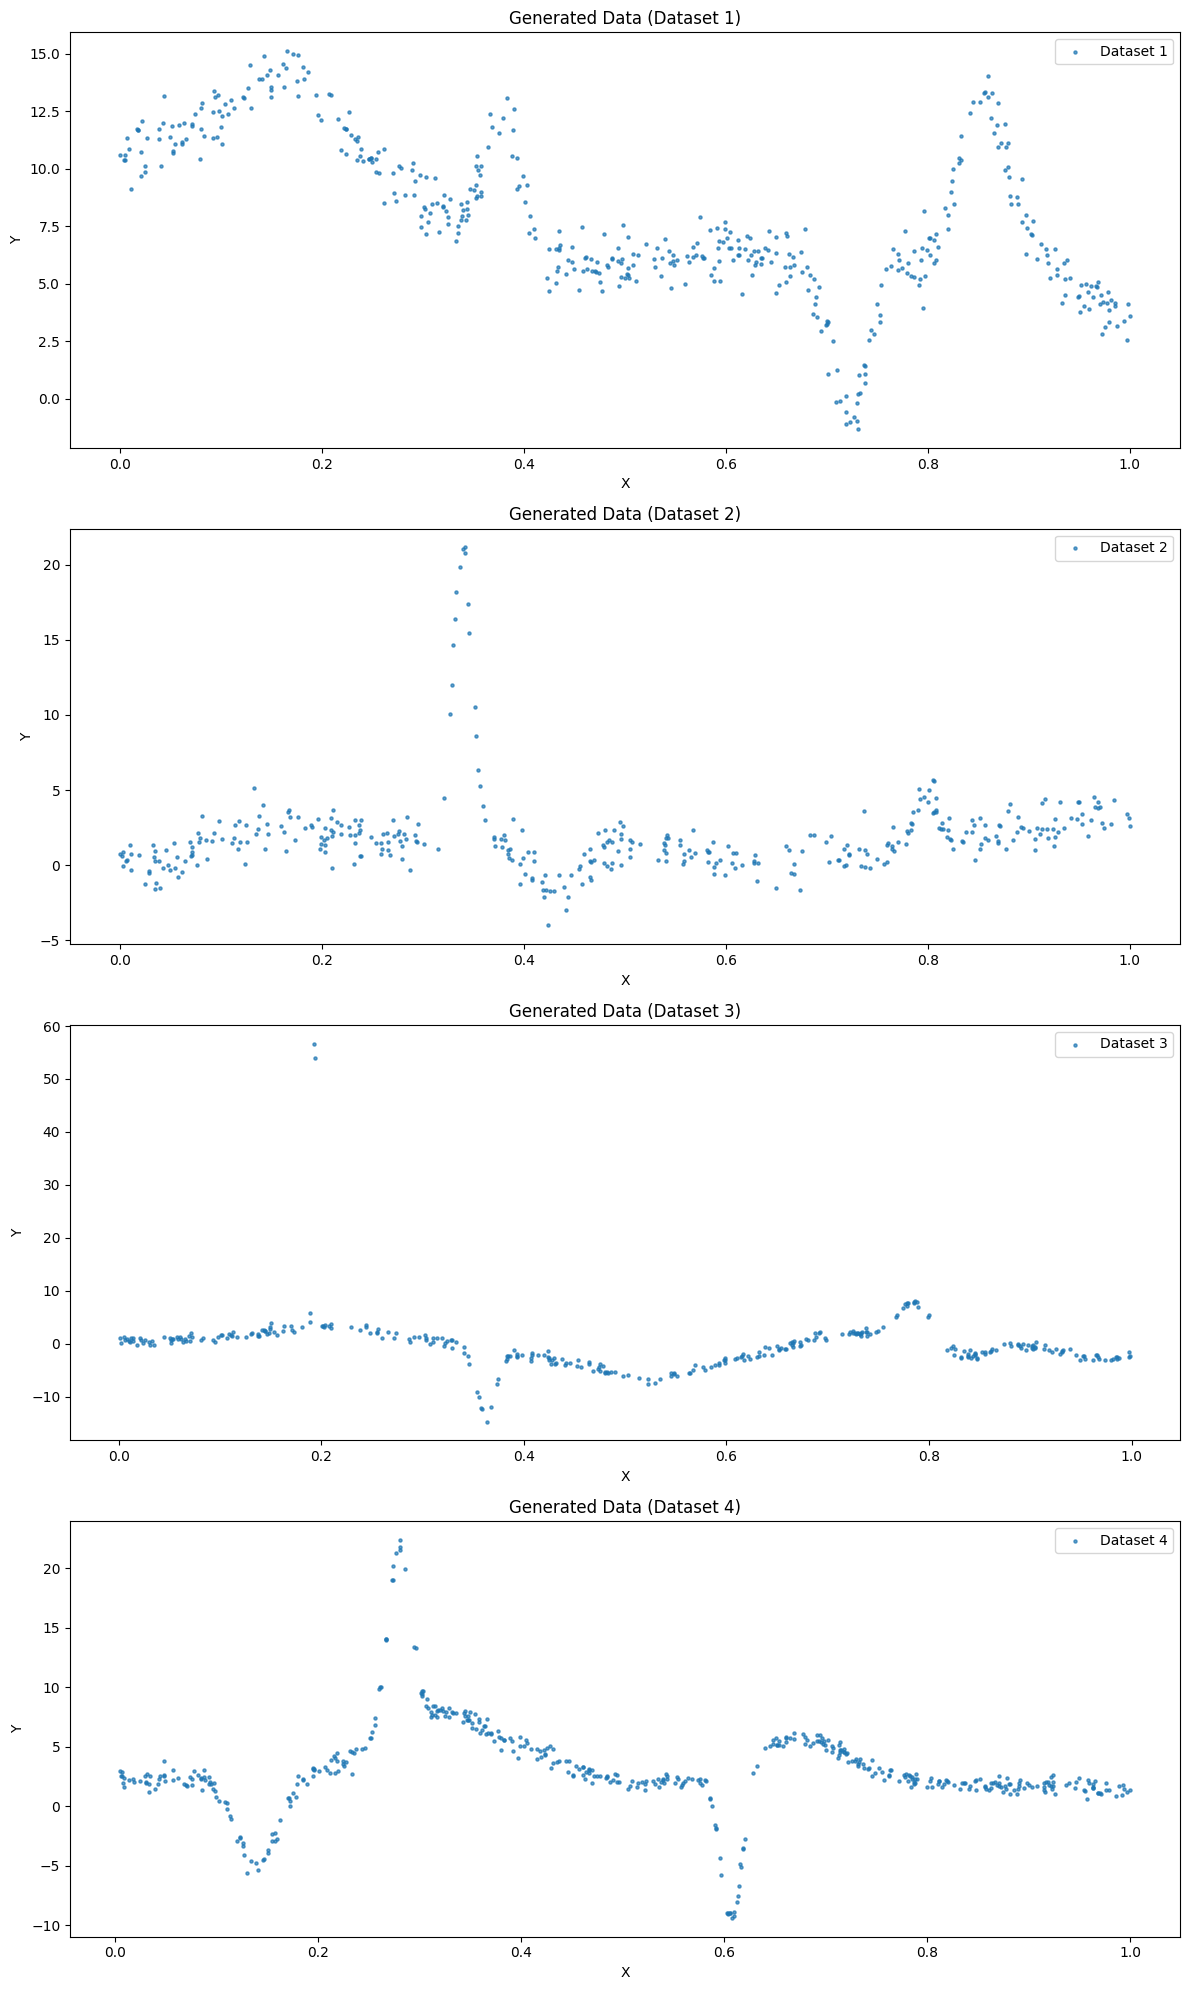

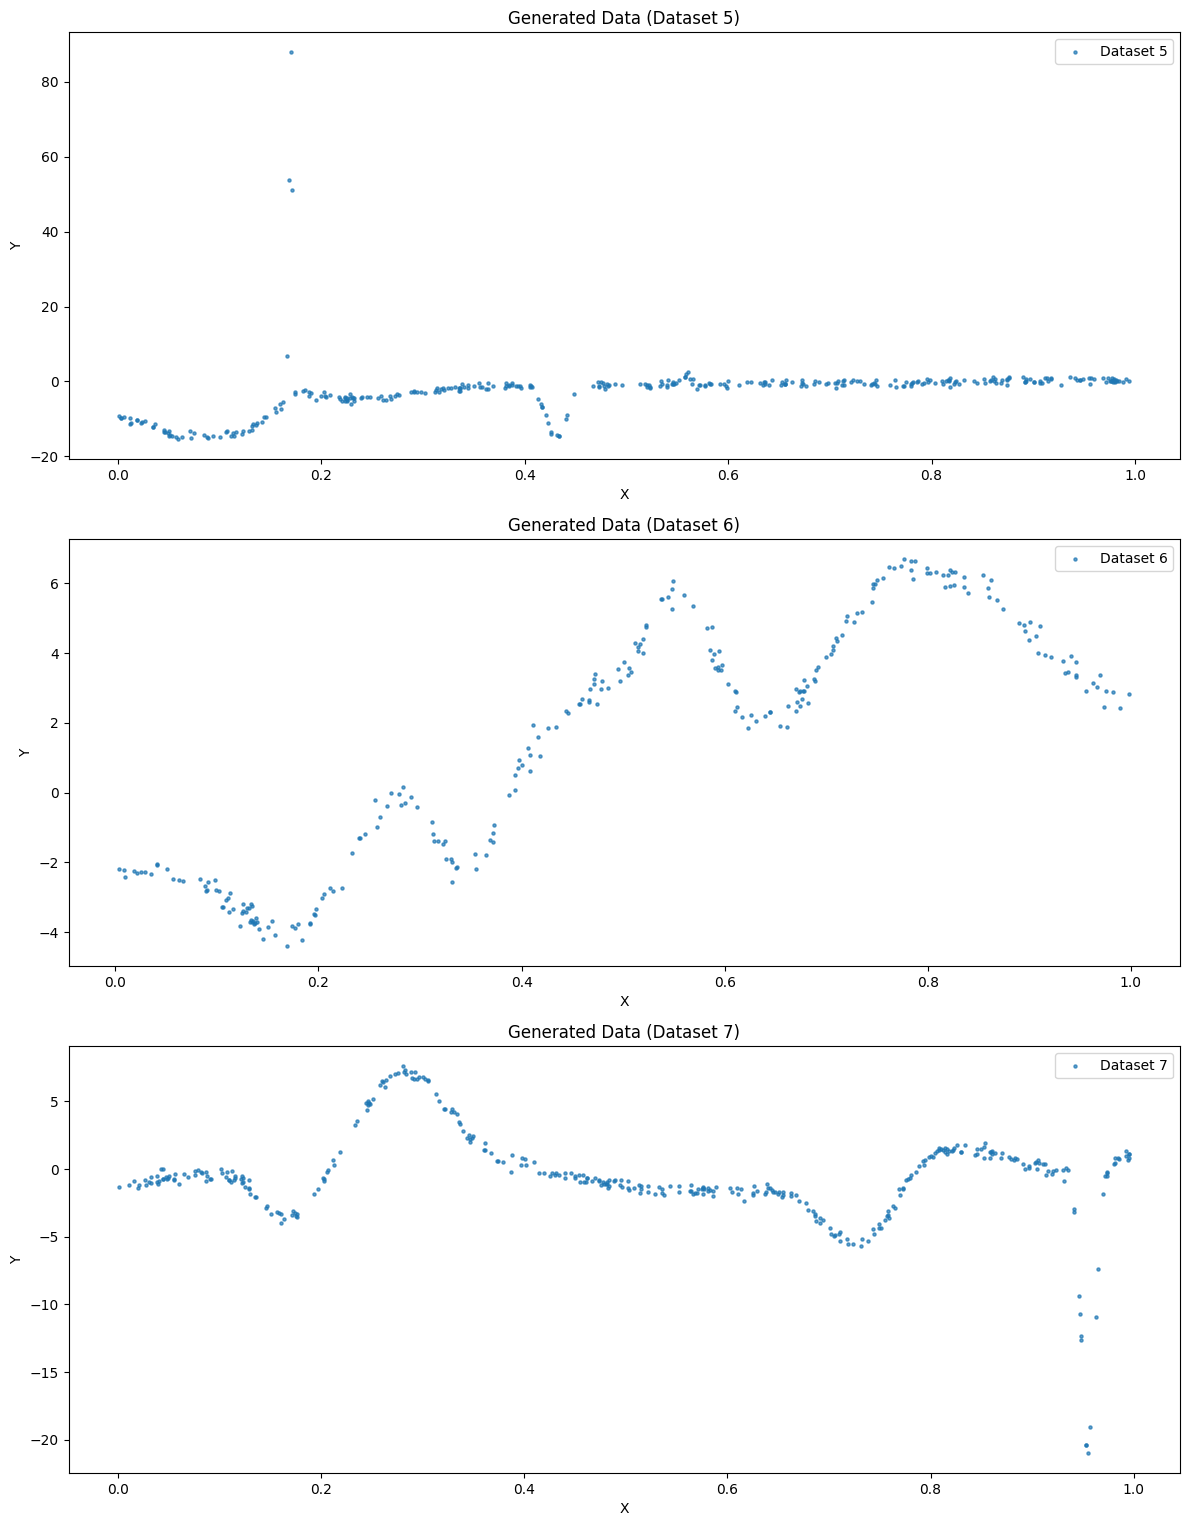

In [7]:
def visualize_datasets(datasets, graphs_per_page=5, max_datasets_to_show=None):
    """
    Visualize multiple datasets, showing a specified number of graphs at a time.

    Parameters:
    - datasets: List or numpy array of (x, y) pairs.
    - graphs_per_page: Number of graphs to show per figure.
    - max_datasets_to_show: Maximum number of datasets to visualize.
    """
    # If max_datasets_to_show is set, limit the datasets
    if max_datasets_to_show is not None:
        datasets = datasets[:max_datasets_to_show]

    num_datasets = len(datasets)
    total_pages = (num_datasets + graphs_per_page - 1) // graphs_per_page  # Calculate total number of pages

    for page in range(total_pages):
        start_idx = page * graphs_per_page
        end_idx = min(start_idx + graphs_per_page, num_datasets)

        plt.figure(figsize=(12, 5 * graphs_per_page))
        for i, dataset in enumerate(datasets[start_idx:end_idx], start=1):
            x_data, y_data = dataset  # Unpack the dataset
            plt.subplot(graphs_per_page, 1, i)
            plt.scatter(x_data, y_data, label=f"Dataset {start_idx + i}", alpha=0.7, s=5)
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.title(f'Generated Data (Dataset {start_idx + i})')
            plt.legend()

        plt.tight_layout()
        plt.show()

# Visualize only 7 datasets, with 4 graphs per page
visualize_datasets(datasets, graphs_per_page=4, max_datasets_to_show=7)


In [ ]:
'''
def generate_multiple_datasets(
    num_samples=200,
    num_datasets=1000,
    wave_amplitude=(3, 6),
    peak_scale=(1, 3),
    valley_scale=(0.3, 0.7)
):
    all_data = []
    for _ in range(num_datasets):
        x = np.linspace(0, 10, num_samples)
        y_sin = np.sin(x) * np.cos(np.random.uniform(0.2, 1.0) * x) * np.random.uniform(*wave_amplitude)
        sharp_peaks = np.random.laplace(loc=0, scale=np.random.uniform(*peak_scale), size=num_samples)
        valleys = np.random.normal(loc=0, scale=np.random.uniform(*valley_scale), size=num_samples)
        y = y_sin + sharp_peaks + valleys
        all_data.append((x, y))
    return all_data
#np.random.seed(42)
datasets = generate_multiple_datasets(
    wave_amplitude=(3, 6),
    peak_scale=(1, 3),
    valley_scale=(0.3, 0.7)
)
print(datasets[0])

plt.figure(figsize=(12, 10))
for i, (x_data, y_data) in enumerate(datasets):
    plt.subplot(5, 1, i+1)
    plt.scatter(x_data, y_data, label=f"Dataset {i+1}", alpha=0.7)  # Scatter plot for points #plt.plot(x_data, y_data, label=f"Dataset {i+1}")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Generated Data with Peaks and Valleys (Dataset {i+1})')
    plt.legend()

plt.tight_layout()
plt.show()

'''


# **STEP 2: Feature Computation**

In [ ]:
#generate_datasets_from_GetADistribution()

In [8]:
def determine_num_clusters(y, max_clusters=10):
    """
    Determine the optimal number of clusters using the elbow method.
    """
    inertias = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(y.reshape(-1, 1))
        inertias.append(kmeans.inertia_)

    # Find the elbow point (can use a heuristic)
    # use the "knee" point approximation
    differences = np.diff(inertias)
    second_differences = np.diff(differences)
    elbow_index = np.argmax(second_differences < 0) + 1  # First inflection point

    return elbow_index  # Optimal number of clusters

In [36]:
def compute_features(x, y):
    features = {}

    # Range
    features['range'] = np.ptp(y)
    features['variance'] = np.var(y)
    features['skew'] = skew(y)
    features['ratio_max_to_mean'] = np.max(np.abs(y)) / np.mean(np.abs(y))
    features['kurtosis'] = kurtosis(y)
    features['peak_to_peak'] = np.ptp(y)

    # First Derivative Features
    dy_dx = np.gradient(y, x)
    features['mean_derivative'] = np.mean(np.abs(dy_dx))
    features['std_derivative'] = np.std(dy_dx)

    # Second Derivative Features
    d2y_dx2 = np.gradient(dy_dx, x)
    features['mean_curvature'] = np.mean(np.abs(d2y_dx2))

    # Fourier Transform Features
    fft_coeffs = np.fft.fft(y)
    dominant_freq = np.argmax(np.abs(fft_coeffs[:len(fft_coeffs)//2]))
    features['dominant_frequency'] = dominant_freq

    # Autocorrelation
    autocorr = np.correlate(y - np.mean(y), y - np.mean(y), mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    features['autocorr_decay'] = np.sum(autocorr > 0.5 * np.max(autocorr))

    # Assuming determine_num_clusters is defined elsewhere
    features['num_clusters'] = determine_num_clusters(y)

    # Density
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(y.reshape(-1, 1))
    log_density = kde.score_samples(y.reshape(-1, 1))
    features['density'] = np.exp(log_density).mean()

    return features

def hybrid_compute_features(x, y):
    features = {}

    # General Statistical Features
    features['kurtosis'] = kurtosis(y)
    features['mean'] = np.mean(y)
    features['std_dev'] = np.std(y)

    # Range and Ratio Features
    max_y, min_y = np.max(y), np.min(y)
    mean_y = np.mean(y)
    features['ratio_max_to_mean'] = max_y / mean_y if mean_y != 0 else 0
    features['ratio_min_to_mean'] = min_y / mean_y if mean_y != 0 else 0

    # Flip-Flop Features
    flip_flops = 0
    for i in range(2, len(y)):
        if np.sign(y[i] - y[i-1]) != np.sign(y[i-1] - y[i-2]):
            flip_flops += 1
    features['flip_flops'] = flip_flops / len(y)

    features['peak_to_peak'] = np.ptp(y)

    # Derivative Features
    dy_dx = np.gradient(y, x)
    features['mean_derivative'] = np.mean(np.abs(dy_dx))
    features['std_derivative'] = np.std(dy_dx)

    # Curvature Features
    d2y_dx2 = np.gradient(dy_dx, x)
    features['mean_curvature'] = np.mean(np.abs(d2y_dx2))
    features['std_curvature'] = np.std(d2y_dx2)

    # Assuming determine_num_clusters is defined elsewhere
    features['num_clusters'] = determine_num_clusters(y)

    return features

def extract_features(final_x, final_y):
    features = {}

    # Initialize variables
    overallMax = np.max(final_y)
    overallMin = np.min(final_y)
    last = 1
    flipFlops = 0
    lastStrength = 1
    runningLineLength = 0
    aveLineLength = 0
    runningDistRan = 0
    aveDistRan = 0

    # Calculate means
    runningMeanY = np.mean(final_y)
    runningMeanX = np.mean(final_x)

    # First pass calculations
    for i in range(1, len(final_y)):
        direction = np.sign(final_y[i] - final_y[i-1])
        if direction != last:
            last = direction
            flipFlops += 1
            aveLineLength += runningLineLength
            runningLineLength = 0
            aveDistRan += runningDistRan
            runningDistRan = 0
        else:
            runningLineLength += 1
            runningDistRan += abs(final_y[i] - final_y[i-1])
            lastStrength = abs(final_y[i] - final_y[i-1])

    # Calculate derived metrics
    overallRange = overallMax - overallMin
    aveDistRan = (aveDistRan/max(1, flipFlops)) / overallRange
    aveLineLength = aveLineLength/max(1, flipFlops)

    # Variance calculations
    runningVarX = np.var(final_x)
    runningVarY = np.var(final_y)

    # Calculate skewness
    skewX = stats.skew(final_x)
    skewY = stats.skew(final_y)

    # Calculate kurtosis
    kurtosis_x = stats.kurtosis(final_x)
    kurtosis_y = stats.kurtosis(final_y)

    # Store all features in dictionary
    features['var_x'] = runningVarX
    features['var_y'] = runningVarY
    features['flip_flops'] = flipFlops/len(final_y)
    features['ave_line_length'] = aveLineLength
    features['ave_dist_ran'] = aveDistRan
    features['skew_x'] = skewX
    features['skew_y'] = skewY
    features['num_points'] = len(final_x)
    features['ratio_max_to_mean'] = overallMax - runningMeanX
    features['ratio_min_to_mean'] = abs(overallMin - runningMeanY)
    features['kurtosis_x'] = kurtosis_x
    features['kurtosis_y'] = kurtosis_y

    return features

# Extract features for all datasets
feature_list = []
for dataset in datasets:
    x, y = dataset  # Unpack dataset
    features = compute_features(x, y)
    feature_list.append(features)

print(feature_list[0])

#Convert feature list to a NumPy array
features = np.array([list(f.values()) for f in feature_list])
print(features.shape)
print(features[0:3])



{'range': 16.430758419701906, 'variance': 11.4121445362488, 'skew': 0.003985400432566013, 'ratio_max_to_mean': 1.9300354930363295, 'kurtosis': -0.3709044142700155, 'peak_to_peak': 16.430758419701906, 'mean_derivative': 1944.1551426644473, 'std_derivative': 5221.766028035005, 'mean_curvature': 3515591.2423100513, 'dominant_frequency': 0, 'autocorr_decay': 27, 'num_clusters': 7, 'density': 0.09489318297717861}
(2000, 13)
[[ 1.64307584e+01  1.14121445e+01  3.98540043e-03  1.93003549e+00
  -3.70904414e-01  1.64307584e+01  1.94415514e+03  5.22176603e+03
   3.51559124e+06  0.00000000e+00  2.70000000e+01  7.00000000e+00
   9.48931830e-02]
 [ 2.51514256e+01  9.46104593e+00  3.78274045e+00  9.51524655e+00
   1.85203737e+01  2.51514256e+01  4.57239831e+03  2.39089452e+04
   1.15784146e+07  0.00000000e+00  7.00000000e+00  1.00000000e+00
   1.75672170e-01]
 [ 7.13850659e+01  2.87345825e+01  6.31607845e+00  1.99354133e+01
   6.51288615e+01  7.13850659e+01  3.76269443e+03  2.91125601e+04
   2.058401

# **STEP 3: GPR Training and Hyperparameter Extraction**

In [19]:
def train_gpr_and_extract_hyperparameters(x, y,i):
    """
    Train a Gaussian Process Regressor and extract hyperparameters.

    Parameters:
    - x: Array of x-values.
    - y: Array of y-values.

    Returns:
    - Amplitude, Length Scale, Noise Level
    """
    # Define the kernel: ConstantKernel (amplitude) * RBF (length scale) + WhiteKernel (noise)
    kernel = C(1.0, (1e-3, 1e4)) * RBF(1.0, (1e-4, 1e4)) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5, 1e3))

    # Initialize the GaussianProcessRegressor with the defined kernel
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gpr.fit(x.reshape(-1, 1), y)

    # Extract hyperparameters
    amplitude = gpr.kernel_.k1.k1.constant_value  # ConstantKernel's amplitude (σf^2)
    length_scale = gpr.kernel_.k1.k2.length_scale  # RBF kernel's length scale (l)
    noise_level = gpr.kernel_.k2.noise_level  # WhiteKernel's noise level (σn^2)
    #print(i)
    if (i % 100 == 0):
      print(i)

    return amplitude, length_scale, noise_level



In [20]:
#%pip install pyautogui

In [21]:
import time

# Step 1: Measure time for fitting GPR directly on all datasets
start_time_gpr = time.time()
i = 0
# Extract hyperparameters for all datasets using GPR fitting
gpr_hyperparameters = []
for dataset in datasets:
    x, y = dataset
    amplitude, length_scale, noise_level = train_gpr_and_extract_hyperparameters(x, y,i)
    gpr_hyperparameters.append([amplitude, length_scale, noise_level])
    i+=1
# Convert hyperparameters to a NumPy array for training
hyperparameters = np.array(gpr_hyperparameters)

end_time_gpr = time.time()
gpr_time = end_time_gpr - start_time_gpr
print(f"Time taken for GPR fitting: {gpr_time:.2f} seconds")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
Time taken for GPR fitting: 28491.36 seconds


In [44]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
features = scaler.fit_transform(features)


# **STEP 4: Save features and hyperparameters**

In [45]:
from google.colab import drive
import numpy as np
import pickle
import torch
from datetime import datetime
import os

# Mount Google Drive first
drive.mount('/content/drive')

def save_data_to_drive(features, feature_list, hyperparameters, base_name='model_data'):
    """
    Save features and GPR hyperparameters to Google Drive.
    Returns the directory path where data was saved.
    """
    # Create a directory in Google Drive
    drive_dir = '/content/drive/MyDrive/ML_saved_data'
    os.makedirs(drive_dir, exist_ok=True)

    # Create timestamped directory name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    save_dir = f'{drive_dir}/{base_name}_{timestamp}'
    os.makedirs(save_dir, exist_ok=True)

    try:
        # Save all data
        np.save(f'{save_dir}/features.npy', features)
        np.save(f'{save_dir}/hyperparameters.npy', hyperparameters)
        with open(f'{save_dir}/feature_list.pkl', 'wb') as f:
            pickle.dump(feature_list, f)

        print(f"\nData successfully saved to Google Drive at: {save_dir}")
        print("You can find it in your Google Drive under 'ML_saved_data' folder")
        return save_dir

    except Exception as e:
        print(f"Error saving data: {str(e)}")
        return None

def load_data_from_drive(data_dir, return_tensors=True):
    """
    Load the saved data from Google Drive.
    data_dir: Full path to the directory containing saved data
    return_tensors: If True, converts numpy arrays to PyTorch tensors
    """
    try:
        # Load the data
        features = np.load(f'{data_dir}/features.npy')
        hyperparameters = np.load(f'{data_dir}/hyperparameters.npy')
        with open(f'{data_dir}/feature_list.pkl', 'rb') as f:
            feature_list = pickle.load(f)

        if return_tensors:
            features = torch.tensor(features, dtype=torch.float32)
            hyperparameters = torch.tensor(hyperparameters, dtype=torch.float32)

        print("\nData loaded successfully!")
        print(f"Features shape: {features.shape}")
        print(f"Hyperparameters shape: {hyperparameters.shape}")
        print(f"Number of feature dictionaries: {len(feature_list)}")

        return features, feature_list, hyperparameters

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None, None, None

def list_saved_data():
    """
    List all saved data directories in Google Drive.
    """
    drive_dir = '/content/drive/MyDrive/ML_saved_data'
    if os.path.exists(drive_dir):
        saved_dirs = os.listdir(drive_dir)
        print("\nAvailable saved data directories:")
        for idx, dir_name in enumerate(saved_dirs, 1):
            print(f"{idx}. {dir_name}")
        return saved_dirs
    else:
        print("No saved data found in Google Drive")
        return []

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
# After your GPR training
save_dir = save_data_to_drive(features, feature_list, hyperparameters)


Data successfully saved to Google Drive at: /content/drive/MyDrive/ML_saved_data/model_data_20241125_0110
You can find it in your Google Drive under 'ML_saved_data' folder


# **STEP 5: Train Neural Network to Predict Hyperparameters**

In [47]:
# First, see what data you have saved
saved_dirs = list_saved_data()



Available saved data directories:
1. model_data_20241123_1758
2. model_data_20241123_1805
3. model_data_20241123_2153
4. model_data_20241123_2208
5. model_data_20241123_2211
6. model_data_20241123_2214
7. model_data_20241123_2215
8. model_data_20241123_2222
9. model_data_20241125_0052
10. model_data_20241125_0106
11. model_data_20241125_0110


In [51]:
'''import os
import numpy as np
import pickle
import torch
from collections import defaultdict

def analyze_feature_signature(feature_list):
    """
    Analyze the feature signature (keys) of the first feature dictionary
    Returns a tuple of (sorted keys, length of feature vector)
    """
    if not feature_list:
        return None, 0

    keys = sorted(feature_list[0].keys())
    return keys, len(keys)

def load_and_categorize_datasets(base_dir):
    """
    Load all datasets and categorize them by their feature signature
    Returns a dictionary where keys are feature signatures and values are lists of loaded data
    """
    datasets_by_signature = defaultdict(list)

    # List all directories
    for dirname in os.listdir(base_dir):
        full_path = os.path.join(base_dir, dirname)
        if not os.path.isdir(full_path):
            continue

        try:
            # Load the data
            features = np.load(os.path.join(full_path, 'features.npy'))
            hyperparameters = np.load(os.path.join(full_path, 'hyperparameters.npy'))
            with open(os.path.join(full_path, 'feature_list.pkl'), 'rb') as f:
                feature_list = pickle.load(f)

            # Get signature
            signature, feat_len = analyze_feature_signature(feature_list)
            if signature:
                # Use feature length as key since it uniquely identifies the generation method
                datasets_by_signature[feat_len].append({
                    'features': features,
                    'hyperparameters': hyperparameters,
                    'feature_list': feature_list,
                    'source_dir': dirname
                })

        except Exception as e:
            print(f"Error loading {dirname}: {str(e)}")
            continue

    return datasets_by_signature

def combine_compatible_datasets(datasets_by_signature):
    """
    Combine datasets with the same feature signature
    Returns a dictionary with combined datasets
    """
    combined_datasets = {}

    for feat_len, dataset_list in datasets_by_signature.items():
        if not dataset_list:
            continue

        # Combine features
        combined_features = np.concatenate([d['features'] for d in dataset_list])

        # Combine hyperparameters
        combined_hyperparameters = np.concatenate([d['hyperparameters'] for d in dataset_list])

        # Combine feature lists
        combined_feature_list = []
        for dataset in dataset_list:
            combined_feature_list.extend(dataset['feature_list'])

        # Get source directories
        source_dirs = [d['source_dir'] for d in dataset_list]

        combined_datasets[feat_len] = {
            'features': torch.tensor(combined_features, dtype=torch.float32),
            'hyperparameters': torch.tensor(combined_hyperparameters, dtype=torch.float32),
            'feature_list': combined_feature_list,
            'source_dirs': source_dirs,
            'total_samples': len(combined_features)
        }

    return combined_datasets

def save_combined_datasets(combined_datasets, base_dir):
    """
    Save the combined datasets to new directories
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")

    for feat_len, data in combined_datasets.items():
        # Create directory for this feature length
        save_dir = os.path.join(base_dir, f'combined_features_{feat_len}_{timestamp}')
        os.makedirs(save_dir, exist_ok=True)

        # Save the data
        np.save(os.path.join(save_dir, 'features.npy'), data['features'].numpy())
        np.save(os.path.join(save_dir, 'hyperparameters.npy'), data['hyperparameters'].numpy())
        with open(os.path.join(save_dir, 'feature_list.pkl'), 'wb') as f:
            pickle.dump(data['feature_list'], f)

        # Save metadata
        metadata = {
            'source_dirs': data['source_dirs'],
            'total_samples': data['total_samples'],
            'feature_length': feat_len
        }
        with open(os.path.join(save_dir, 'metadata.pkl'), 'wb') as f:
            pickle.dump(metadata, f)

    return True

def process_and_combine_all_datasets(base_dir='/content/drive/MyDrive/ML_saved_data'):
    """
    Main function to process and combine all datasets
    """
    print("Loading and categorizing datasets...")
    datasets_by_signature = load_and_categorize_datasets(base_dir)

    print("\nFound datasets with following feature lengths:")
    for feat_len, datasets in datasets_by_signature.items():
        print(f"Feature length {feat_len}: {len(datasets)} datasets")

    print("\nCombining compatible datasets...")
    combined_datasets = combine_compatible_datasets(datasets_by_signature)

    print("\nSummary of combined datasets:")
    for feat_len, data in combined_datasets.items():
        print(f"\nFeature length {feat_len}:")
        print(f"Total samples: {data['total_samples']}")
        print(f"Source directories: {', '.join(data['source_dirs'])}")
        print(f"Features shape: {data['features'].shape}")
        print(f"Hyperparameters shape: {data['hyperparameters'].shape}")

    print("\nSaving combined datasets...")
    save_combined_datasets(combined_datasets, base_dir)
    print("Done!")

    return combined_datasets'''

In [52]:
#combined_datasets = process_and_combine_all_datasets()

Loading and categorizing datasets...

Found datasets with following feature lengths:
Feature length 12: 8 datasets
Feature length 13: 3 datasets

Combining compatible datasets...

Summary of combined datasets:

Feature length 12:
Total samples: 7110
Source directories: model_data_20241123_1758, model_data_20241123_1805, model_data_20241123_2153, model_data_20241123_2208, model_data_20241123_2214, model_data_20241123_2215, model_data_20241123_2222, model_data_20241125_0052
Features shape: torch.Size([7110, 12])
Hyperparameters shape: torch.Size([7110, 3])

Feature length 13:
Total samples: 5000
Source directories: model_data_20241123_2211, model_data_20241125_0106, model_data_20241125_0110
Features shape: torch.Size([5000, 13])
Hyperparameters shape: torch.Size([5000, 3])

Saving combined datasets...
Done!


In [53]:
'''import os

def list_combined_datasets(base_dir='/content/drive/MyDrive/ML_saved_data'):
    """List all combined datasets in the directory"""
    combined_datasets = [d for d in os.listdir(base_dir) if d.startswith('combined_features_')]

    print("\nAvailable combined datasets:")
    for idx, dirname in enumerate(combined_datasets, 1):
        print(f"{idx}. {dirname}")
    return combined_datasets

# List the combined datasets
combined_dirs = list_combined_datasets()'''


Available combined datasets:
1. combined_features_12_20241125_0237
2. combined_features_13_20241125_0237


In [58]:

class EnhancedPredictor(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return self.network(x)



# Define ImprovedHyperparameterPredictor
class ImprovedHyperparameterPredictor(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        return self.network(x)


# Define HyperparameterPredictor for a simple architecture
class HyperparameterPredictor(nn.Module):
    def __init__(self, input_size, output_size):
        super(HyperparameterPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x




# Load the data from your chosen directory
# Replace with your actual directory path from the list
data_dir = '/content/drive/MyDrive/ML_saved_data/model_data_20241125_0110'
features, feature_list, hyperparameters = load_data_from_drive(data_dir)

features_tensor = features.clone().detach().float()
hyperparameters_tensor = hyperparameters.clone().detach().float()


# Split into training and testing sets
train_features, test_features, train_hyperparams, test_hyperparams = train_test_split(
    features_tensor, hyperparameters_tensor, test_size=0.3, random_state=42
)

# Initialize the model
input_size = features.shape[1]
output_size = hyperparameters.shape[1]
model = EnhancedPredictor(input_size, output_size)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    predictions = model(train_features)
    loss = criterion(predictions, train_hyperparams)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Print progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(test_features)

# Calculate R^2 score
r2 = r2_score(test_hyperparams.numpy(), test_predictions.numpy())
print(f"R^2 Score: {r2:.4f}")
hyperparam_names = ['Amplitude (σf^2)', 'Length Scale (l)', 'Noise Level (σn^2)']
for i, name in enumerate(hyperparam_names):
    r2 = r2_score(test_hyperparams[:, i].numpy(), test_predictions[:, i].numpy())
    print(f"R² Score for {name}: {r2:.4f}")




Data loaded successfully!
Features shape: torch.Size([2000, 13])
Hyperparameters shape: torch.Size([2000, 3])
Number of feature dictionaries: 2000
Epoch 0/5000, Loss: 915.5361
Epoch 50/5000, Loss: 510.3983
Epoch 100/5000, Loss: 142.4623
Epoch 150/5000, Loss: 84.5073
Epoch 200/5000, Loss: 82.3742
Epoch 250/5000, Loss: 69.1499
Epoch 300/5000, Loss: 57.4436
Epoch 350/5000, Loss: 66.4704
Epoch 400/5000, Loss: 48.5550
Epoch 450/5000, Loss: 47.4097
Epoch 500/5000, Loss: 47.9584
Epoch 550/5000, Loss: 55.1484
Epoch 600/5000, Loss: 42.8794
Epoch 650/5000, Loss: 43.1546
Epoch 700/5000, Loss: 38.6084
Epoch 750/5000, Loss: 41.9706
Epoch 800/5000, Loss: 34.8538
Epoch 850/5000, Loss: 38.3589
Epoch 900/5000, Loss: 33.8399
Epoch 950/5000, Loss: 33.4290
Epoch 1000/5000, Loss: 34.9097
Epoch 1050/5000, Loss: 30.9917
Epoch 1100/5000, Loss: 34.0238
Epoch 1150/5000, Loss: 31.4803
Epoch 1200/5000, Loss: 25.8309
Epoch 1250/5000, Loss: 26.2692
Epoch 1300/5000, Loss: 28.9268
Epoch 1350/5000, Loss: 24.5677
Epoc

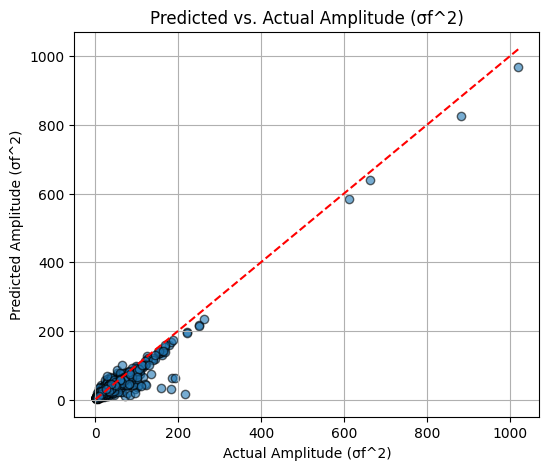

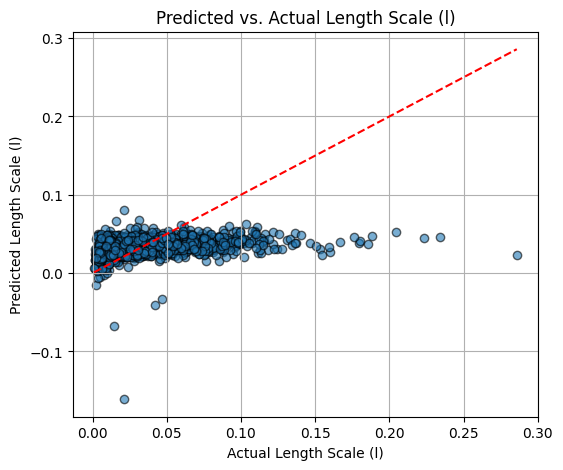

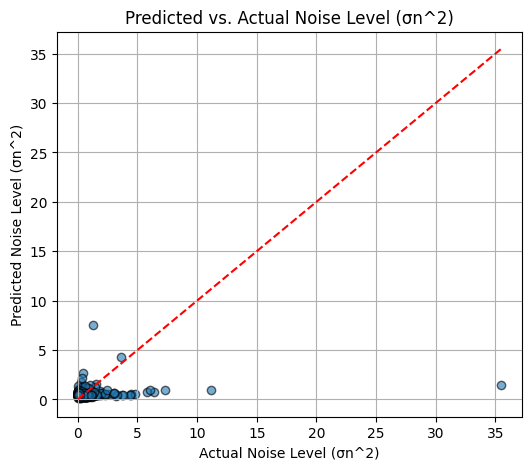

In [49]:
import matplotlib.pyplot as plt

# Predicted hyperparameters from the neural network
with torch.no_grad():
    predicted_hyperparams = model(features_tensor).numpy()

# Plot each hyperparameter
hyperparam_names = ['Amplitude (σf^2)', 'Length Scale (l)', 'Noise Level (σn^2)']
for i in range(hyperparameters.shape[1]):
    plt.figure(figsize=(6, 5))
    plt.scatter(hyperparameters[:, i], predicted_hyperparams[:, i], alpha=0.6, edgecolors='k')
    plt.plot([min(hyperparameters[:, i]), max(hyperparameters[:, i])],
             [min(hyperparameters[:, i]), max(hyperparameters[:, i])], 'r--')
    plt.xlabel(f'Actual {hyperparam_names[i]}')
    plt.ylabel(f'Predicted {hyperparam_names[i]}')
    plt.title(f'Predicted vs. Actual {hyperparam_names[i]}')
    plt.grid(True)
    plt.show()


In [28]:
def evaluate_gpr_with_hyperparameters(x, y, amplitude, length_scale, noise_level):
    # Define kernel with provided hyperparameters
    kernel = C(amplitude) * RBF(length_scale) + WhiteKernel(noise_level=noise_level)

    # Initialize and fit GPR model
    gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None)  # Disable optimization
    gpr.fit(x.reshape(-1, 1), y)

    # Make predictions
    x_pred = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred, y_std = gpr.predict(x_pred, return_std=True)

    return x_pred, y_pred, y_std



In [50]:
# Step 2: Measure time for fitting GPR using predicted hyperparameters
start_time_predicted = time.time()

# Predict hyperparameters for all datasets
predicted_hyperparams = model(features_tensor).detach().numpy()
print(predicted_hyperparams.shape)

# Fit GPR with predicted hyperparameters
for dataset, pred_hyperparam in zip(datasets, predicted_hyperparams):
    x, y = dataset
    amplitude, length_scale, noise_level = pred_hyperparam
    x_pred, y_pred, y_std = evaluate_gpr_with_hyperparameters(x, y, amplitude, length_scale, noise_level)

end_time_predicted = time.time()
predicted_time = end_time_predicted - start_time_predicted
print(f"Time taken for GPR with predicted hyperparameters: {predicted_time:.2f} seconds")


(2000, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:307: RuntimeWarning: invalid value encountered in log
  return np.log(np.hstack(theta))
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:307: RuntimeWarning: invalid value encountered in log
  return np.log(np.hstack(theta))
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:307: RuntimeWarning: invalid value encountered in log
  return np.log(np.hstack(theta))
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:307: RuntimeWarning: invalid value encountered in log
  return np.log(np.hstack(theta))
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:307: RuntimeWarning: invalid value encountered in log
  return np.log(np.hstack(theta))
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:307: RuntimeWarning: invalid value encountered in log
  return np.log(np.hstack(theta))
/usr/local/lib/p

Time taken for GPR with predicted hyperparameters: 112.02 seconds


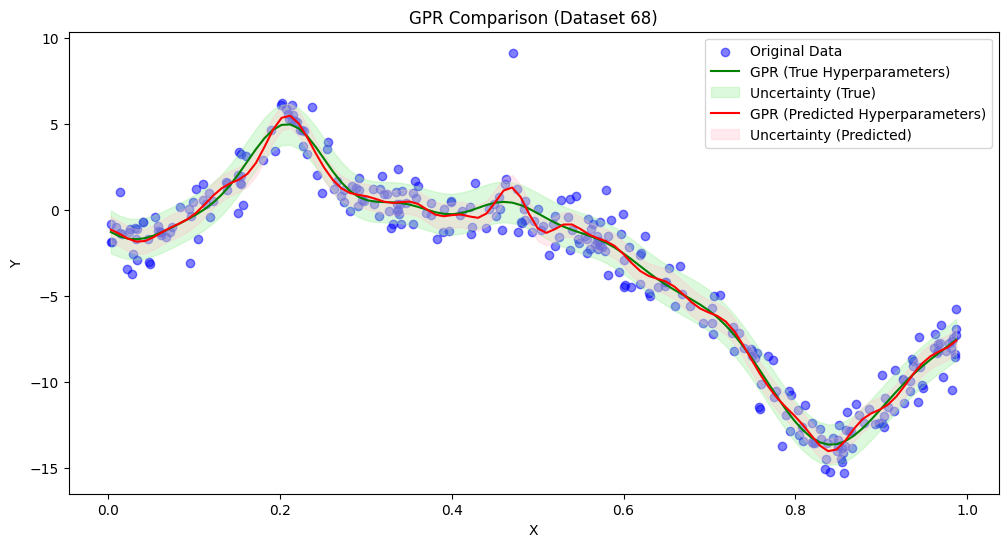

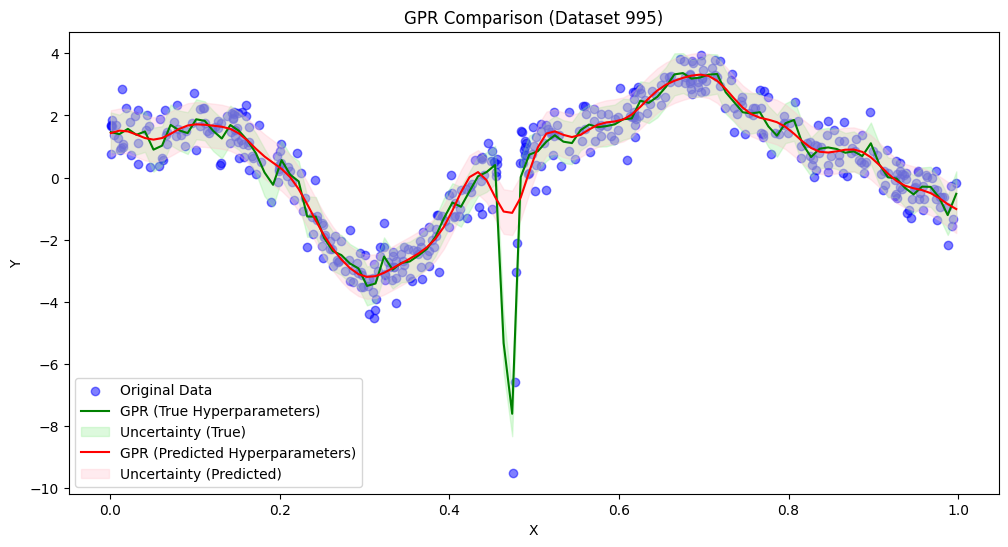

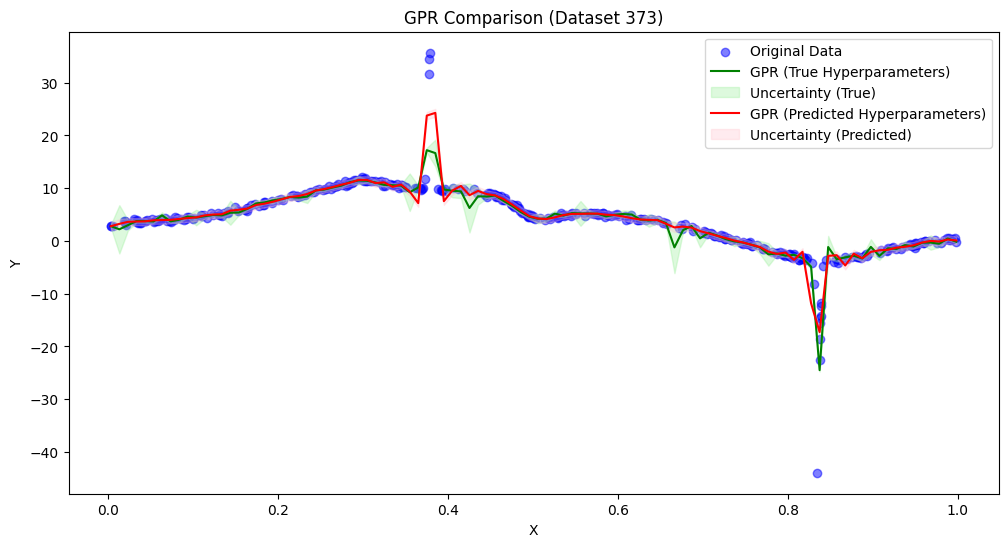

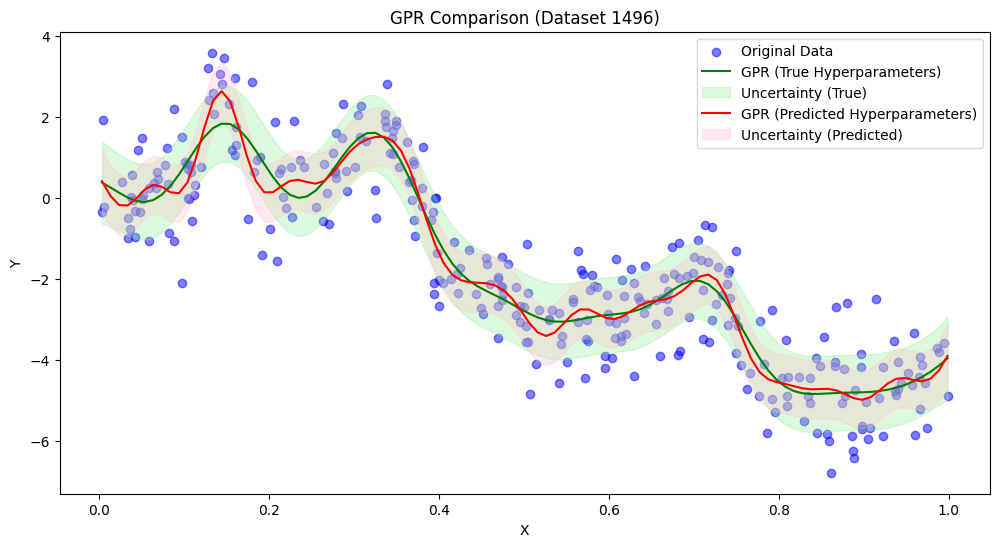

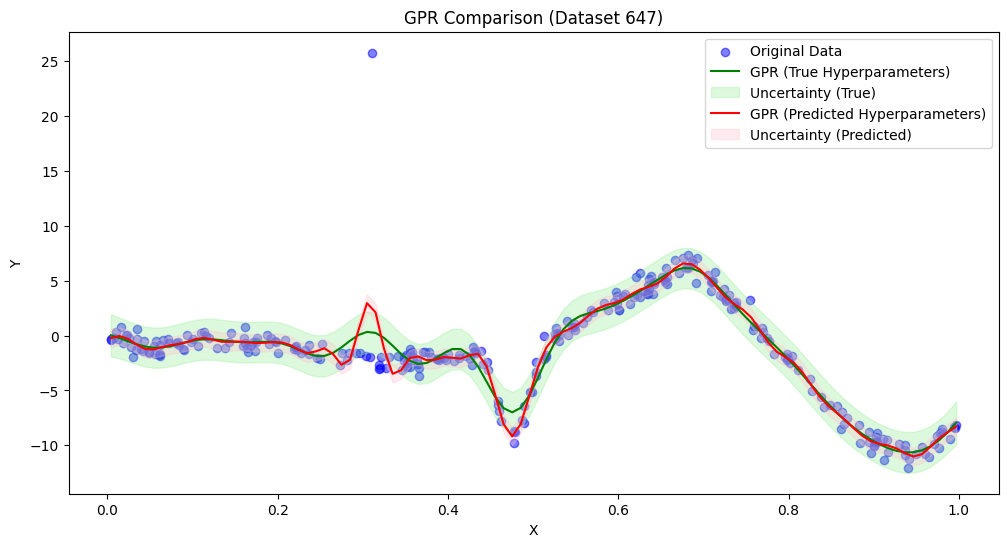

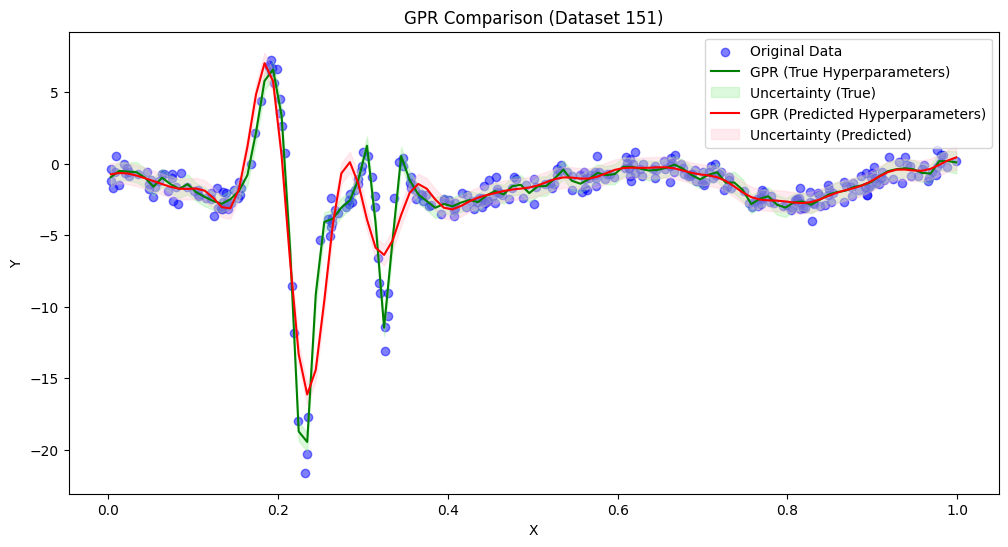

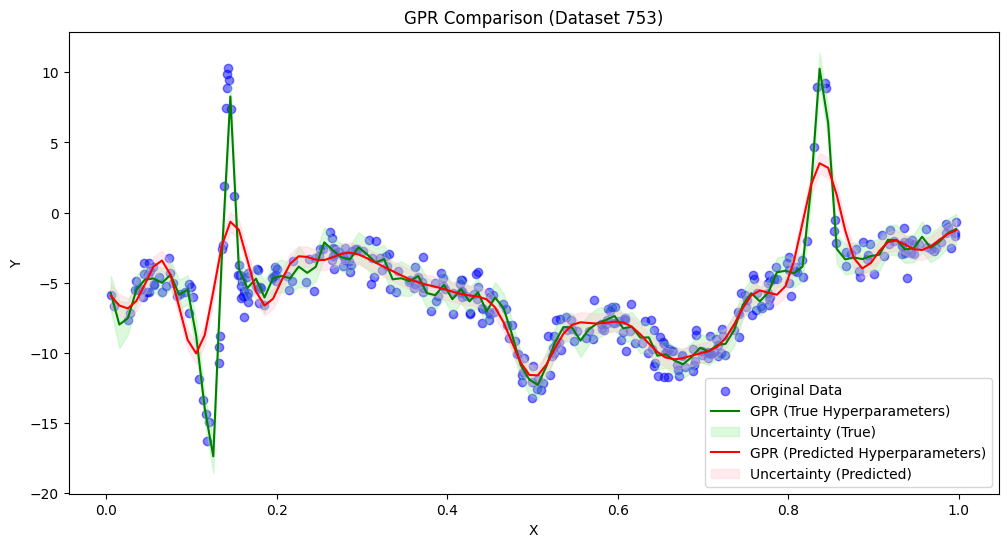

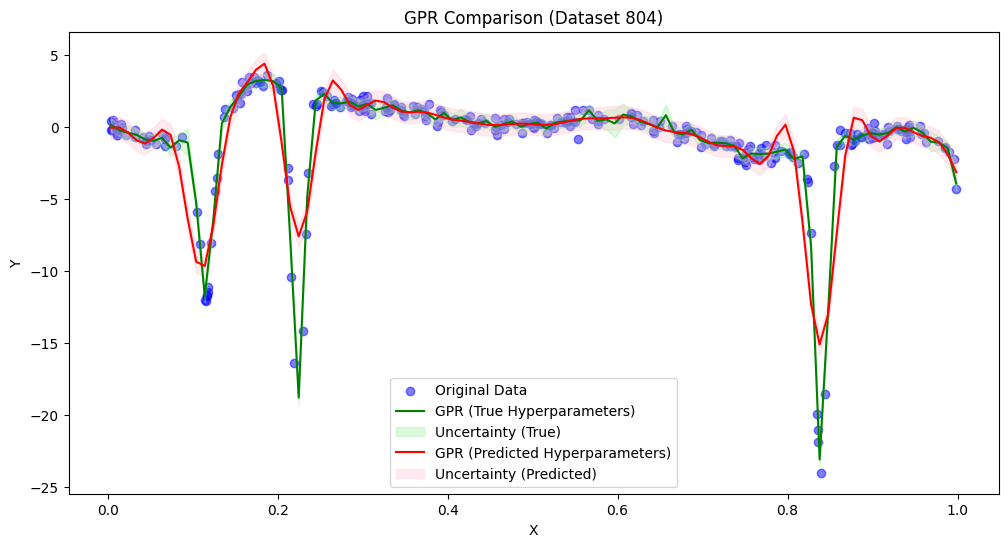

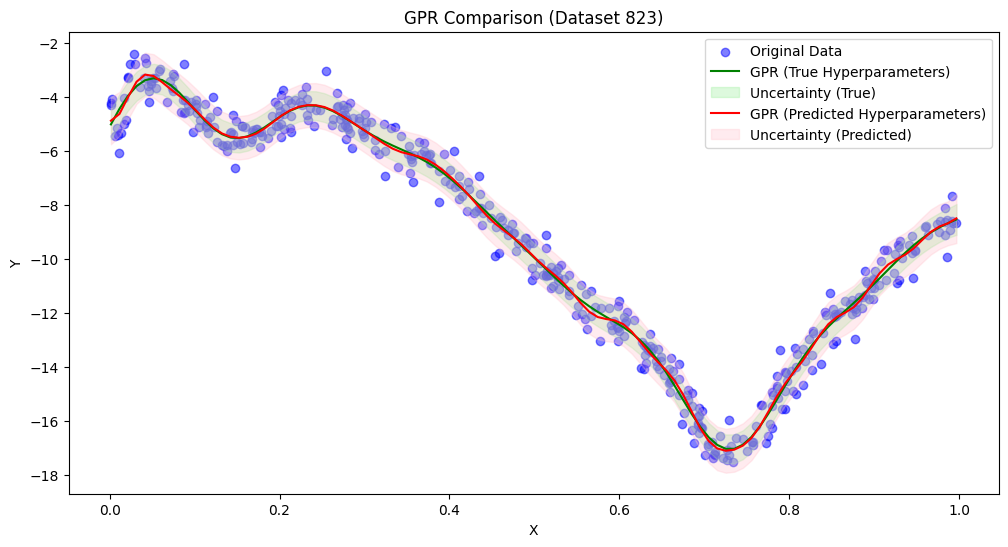

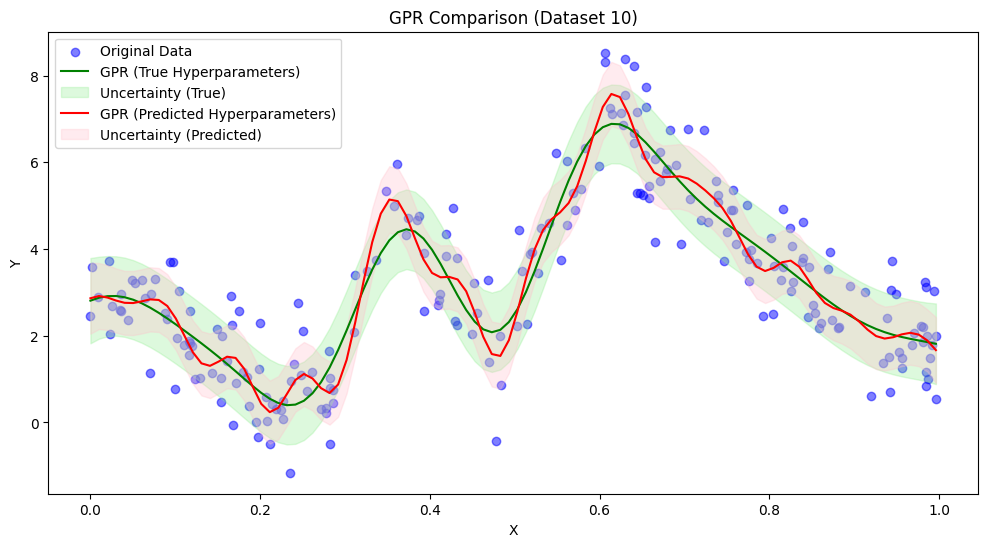

In [34]:
# Step 4: Visualization for a few datasets
import random
random_indices = random.sample(range(len(datasets)), 10)  # Select random datasets for visualization

for idx in random_indices:
    x, y = datasets[idx]
    true_amplitude, true_length_scale, true_noise_level = gpr_hyperparameters[idx]
    pred_amplitude, pred_length_scale, pred_noise_level = predicted_hyperparams[idx]

    # Evaluate GPR with true hyperparameters
    x_pred_true, y_pred_true, y_std_true = evaluate_gpr_with_hyperparameters(
        x, y, true_amplitude, true_length_scale, true_noise_level
    )

    # Evaluate GPR with predicted hyperparameters
    x_pred_pred, y_pred_pred, y_std_pred = evaluate_gpr_with_hyperparameters(
        x, y, pred_amplitude, pred_length_scale, pred_noise_level
    )

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.scatter(x, y, color='blue', label='Original Data', alpha=0.5)
    plt.plot(x_pred_true, y_pred_true, color='green', label='GPR (True Hyperparameters)')
    plt.fill_between(x_pred_true.flatten(), y_pred_true - y_std_true, y_pred_true + y_std_true,
                     color='lightgreen', alpha=0.3, label='Uncertainty (True)')
    plt.plot(x_pred_pred, y_pred_pred, color='red', label='GPR (Predicted Hyperparameters)')
    plt.fill_between(x_pred_pred.flatten(), y_pred_pred - y_std_pred, y_pred_pred + y_std_pred,
                     color='pink', alpha=0.3, label='Uncertainty (Predicted)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'GPR Comparison (Dataset {idx})')
    plt.legend()
    plt.show()


In [ ]:
 from sklearn.metrics import mean_squared_error

def evaluate_model_performance(x, y, amplitude, length_scale, noise_level):
    # Create and fit GPR model
    kernel = C(amplitude) * RBF(length_scale) + WhiteKernel(noise_level=noise_level)
    gpr = GaussianProcessRegressor(kernel=kernel, optimizer=None)
    gpr.fit(x.reshape(-1, 1), y)

    # Predictions on training data
    y_pred = gpr.predict(x.reshape(-1, 1))
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    return mse, r2

# Calculate performance for all datasets
mse_actual, r2_actual, mse_predicted, r2_predicted = [], [], [], []
for idx, (x, y) in enumerate(datasets):
    # Actual hyperparameters
    actual_amplitude, actual_length_scale, actual_noise_level = hyperparameters[idx]
    mse_a, r2_a = evaluate_model_performance(x, y, actual_amplitude, actual_length_scale, actual_noise_level)

    # Predicted hyperparameters
    pred_amplitude, pred_length_scale, pred_noise_level = predicted_hyperparams[idx]
    mse_p, r2_p = evaluate_model_performance(x, y, pred_amplitude, pred_length_scale, pred_noise_level)

    mse_actual.append(mse_a)
    r2_actual.append(r2_a)
    mse_predicted.append(mse_p)
    r2_predicted.append(r2_p)

# Plot comparison of MSE and R^2
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.boxplot([mse_actual, mse_predicted], labels=['Actual Hyperparams', 'Predicted Hyperparams'])
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE')

plt.subplot(1, 2, 2)
plt.boxplot([r2_actual, r2_predicted], labels=['Actual Hyperparams', 'Predicted Hyperparams'])
plt.ylabel('R^2 Score')
plt.title('Comparison of R^2 Score')

plt.tight_layout()
plt.show()
